In [1]:
# Python imports to be incorporated
# Python ≥3.5 is required
# Anaconda prompt
# conda activate tfradeon
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
try:
    if not tf.config.list_physical_devices('GPU'):
        assert tf.__version__ >= "2.0"
except:
    if not tf.test.is_gpu_available():
        assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import pandas as pd
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
    

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
print(tf.config.list_physical_devices('GPU')) 

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [3]:
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

In [4]:
features=data_train.columns[data_train.columns!='label']
X_train, X_tester, y_train, y_tester = train_test_split((data_train[features]/ 255.0), data_train[['label']],test_size=0.2,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=(1/9),random_state=42)
X_test=(data_test/255.0)
X_train.shape

(29866, 784)

In [5]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    digit_dir = os.path.join("datasets", "digits")
    os.makedirs(digit_dir, exist_ok=True)
    path_format = os.path.join(digit_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths
n_inputs =X_train.shape[-1]
#@tf.function
def preprocess_ne(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x) / 255.0, y
def preprocess_og(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x), y
def csv_reader_dataset_og(filepaths, repeat=1, n_readers=5,  # number of files or filepaths
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    
    # pick multiple files randomly and read them simultaneously, interleaving their records
    # list_files() function returns a dataset that "shuffles" the file paths, then repeat 'repeat' times
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    
    
    
    # interleave() method to read from cycle_length(=n_readers) files at a time and
    # "interleave their lines" (called cycle) : reading one line at a time from each until all datasets are out of items
    # Then it will get the next five file paths from the 'dataset' and interleave them the same way,
    # and so on until it runs out of file paths
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip the header row via map_func
        cycle_length=n_readers, # 'interleave' pull cycle_length(=n_readers) file paths(1 by 1) from the 'dataset'
        num_parallel_calls=n_read_threads) 
    #and for each one(filepath) it will call the function you gave it(lambda) to create a new dataset(TextLineDataset)
    #the interleave dataset including cycle_length(=n_readers) datasets
    
    
    # Then on top of that you can add a shuffling buffer using the shuffle() method
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess_og, num_parallel_calls=n_parse_threads)  # call preprocess()
    dataset = dataset.batch(batch_size) #group the items of the previous dataset in batches of 'batch_size' items
    
    
    # See the notes below
    return dataset.prefetch(1)
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,  # number of files or filepaths
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    
    # pick multiple files randomly and read them simultaneously, interleaving their records
    # list_files() function returns a dataset that "shuffles" the file paths, then repeat 'repeat' times
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    
    
    
    # interleave() method to read from cycle_length(=n_readers) files at a time and
    # "interleave their lines" (called cycle) : reading one line at a time from each until all datasets are out of items
    # Then it will get the next five file paths from the 'dataset' and interleave them the same way,
    # and so on until it runs out of file paths
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip the header row via map_func
        cycle_length=n_readers, # 'interleave' pull cycle_length(=n_readers) file paths(1 by 1) from the 'dataset'
        num_parallel_calls=n_read_threads) 
    #and for each one(filepath) it will call the function you gave it(lambda) to create a new dataset(TextLineDataset)
    #the interleave dataset including cycle_length(=n_readers) datasets
    
    
    # Then on top of that you can add a shuffling buffer using the shuffle() method
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess_ne, num_parallel_calls=n_parse_threads)  # call preprocess()
    dataset = dataset.batch(batch_size) #group the items of the previous dataset in batches of 'batch_size' items
    
    
    # See the notes below
    return dataset.prefetch(1)

In [6]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data=np.c_[X_tester, y_tester]
header_cols = data_train.columns
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)
try:
    if not tf.config.list_physical_devices('GPU'):
        tf.random.set_seed(42)
    else:
        tf.random.set_random_seed(42)
except:
    if not tf.test.is_gpu_available():
        tf.random.set_random_seed(42)
    else:
        tf.random.set_seed(42)
train_set = csv_reader_dataset_og(train_filepaths, repeat=None)
valid_set = csv_reader_dataset_og(valid_filepaths)
test_set = csv_reader_dataset_og(test_filepaths)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [7]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0)
        self.stds_ = np.std(data_sample, axis=0)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
std_layer = Standardization()
std_layer.adapt(X_train)
beta=1.1
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return (1/beta)*tf.math.log(tf.exp(beta*z) + 1.0)
alpha=0.009#0.01
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(alpha * weights))
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [8]:
try:
    if not tf.config.list_physical_devices('GPU'):
        tf.random.set_seed(42)
    else:
        tf.random.set_random_seed(42)
except:
    if not tf.test.is_gpu_available():
        tf.random.set_random_seed(42)
    else:
        tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Lambda(std_layer,input_shape=X_train.shape[1:]),
    keras.layers.Reshape((28, 28,1)),
    keras.layers.Conv2D(64, 7, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='selu',padding='same', kernel_initializer="lecun_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="tanh",kernel_initializer=my_glorot_initializer,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32,activation=my_softplus,kernel_initializer=my_glorot_initializer,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation="softmax",kernel_regularizer=my_l1_regularizer,kernel_constraint=my_positive_weights)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 784)               0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        3

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True,clipnorm=1.0),
              metrics=["accuracy"])
batch_size=32
val_batch_size=64
history = model.fit(train_set, steps_per_epoch=(len(X_train)//batch_size), epochs=30,validation_data=valid_set)

Epoch 1/30
933/933 [==============================] - 77s 78ms/step - loss: 0.5403 - accuracy: 0.9259 - val_loss: 0.2850 - val_accuracy: 0.9756
Epoch 2/30
933/933 [==============================] - 70s 75ms/step - loss: 0.3179 - accuracy: 0.9749 - val_loss: 0.2230 - val_accuracy: 0.9837
Epoch 3/30
933/933 [==============================] - 217s 233ms/step - loss: 0.2590 - accuracy: 0.9835 - val_loss: 0.2212 - val_accuracy: 0.9813
Epoch 4/30
933/933 [==============================] - 70s 75ms/step - loss: 0.2296 - accuracy: 0.9880 - val_loss: 0.1926 - val_accuracy: 0.9855
Epoch 5/30
933/933 [==============================] - 74s 80ms/step - loss: 0.2095 - accuracy: 0.9895 - val_loss: 0.1939 - val_accuracy: 0.9855
Epoch 6/30
933/933 [==============================] - 70s 75ms/step - loss: 0.1946 - accuracy: 0.9925 - val_loss: 0.1771 - val_accuracy: 0.9898
Epoch 7/30
933/933 [==============================] - 69s 74ms/step - loss: 0.1839 - accuracy: 0.9937 - val_loss: 0.1756 - val_accurac

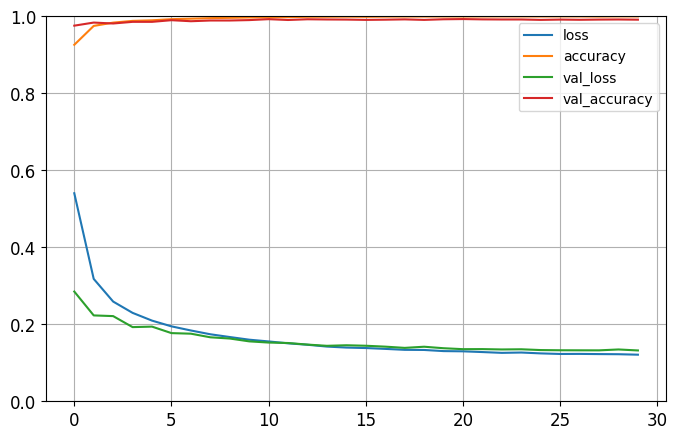

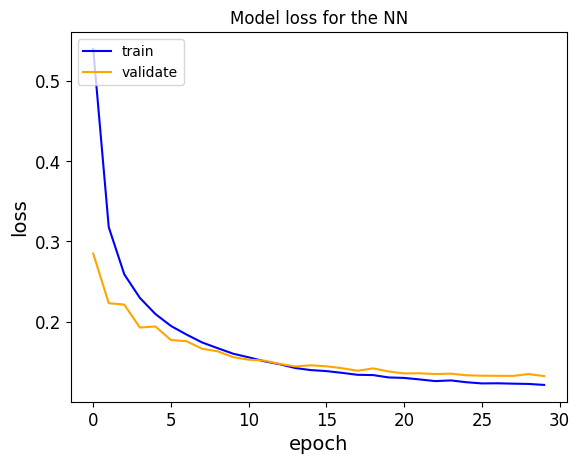

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'orange')
plt.title('Model loss for the NN')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

In [11]:
score = model.evaluate(X_tester, y_tester)
score

263/263 [==============================] - 8s 27ms/step - loss: 0.1227 - accuracy: 0.9930


[0.1226513534784317, 0.992976188659668]

In [12]:
y_pred = np.argmax(model.predict(X_test),axis=1)
id_values=pd.read_csv('sample_submission.csv')['ImageId']

875/875 [==============================] - 18s 20ms/step


In [13]:
pd.DataFrame({'ImageId':np.array(id_values.values),'Label':np.array(y_pred)}).to_csv('submission.csv',index=False)